## 1. 引入必要的套件

In [9]:
pip install denoising-diffusion-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## 2. 準備資料集

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17662329.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491354.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4511883.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5269855.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. DIP 模型

In [3]:
class DIP(nn.Module):
  def __init__(self):
    super(DIP, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    return x

## 4. Add noise 步驟

In [4]:
def add_noise(img, noise_level):
    noise = torch.randn_like(img) * noise_level
    return img + noise

def ddpm_denoise(model, noisy_img, noise_level):
    output = model(noisy_img)
    return output

## 5. 訓練函數

In [5]:
def train_dip_with_ddpm_guidance(dip_model, trainloader, epochs=10, noise_levels=[0.1, 0.2, 0.3], display_interval=5):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

  losses = []

  for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, _) in enumerate(trainloader):
      images = images.cuda()
      optimizer.zero_grad()

      noisy_images = [add_noise(images, nl) for nl in noise_levels]
      loss = 0.0

      for noisy_img in noisy_images:
          output = dip_model(noisy_img)
          loss += criterion(output, images)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

  return losses

In [6]:
import torch
import matplotlib.pyplot as plt

def display_images(clean_img, noisy_img, denoised_img, num_images=5):
  clean_img = clean_img.cpu().detach().numpy()
  noisy_img = noisy_img.cpu().detach().numpy()
  denoised_img = denoised_img.cpu().detach().numpy()

  fig, axes = plt.subplots(num_images, 3, figsize=(9, num_images * 3), squeeze=False)
  fig.subplots_adjust(hspace=0.01)

  for i in range(num_images):
    axes[i, 0].imshow(clean_img[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Origin')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy_img[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Noisy')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(denoised_img[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Denoised')
    axes[i, 2].axis('off')

  plt.show()

## 6. 訓練模型並記錄 loss

* DDPM

Epoch [1/10], Average Loss: 0.1808
Epoch [2/10], Average Loss: 0.0915
Epoch [3/10], Average Loss: 0.0792
Epoch [4/10], Average Loss: 0.0726
Epoch [5/10], Average Loss: 0.0672
Epoch [6/10], Average Loss: 0.0646
Epoch [7/10], Average Loss: 0.0629
Epoch [8/10], Average Loss: 0.0616
Epoch [9/10], Average Loss: 0.0610
Epoch [10/10], Average Loss: 0.0594


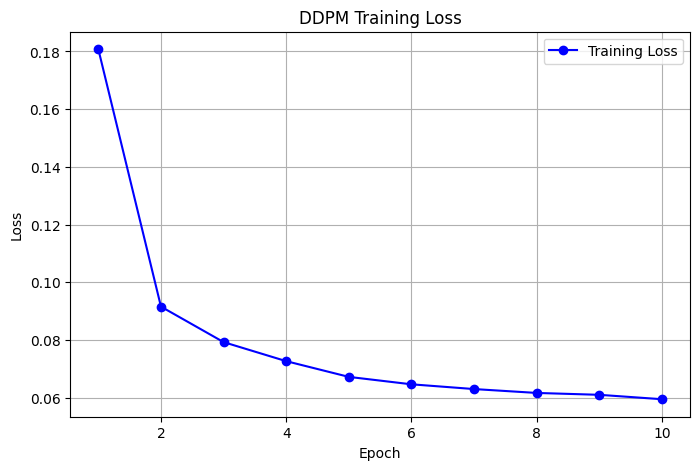

In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

# DDPM 模型
model = Unet(dim=28, channels=1, dim_mults=(1, 2, 4)).cuda()
diffusion = GaussianDiffusion(
    model,
    image_size=28,
    timesteps=1000,  # number of steps
).cuda()

def train_ddpm(diffusion, trainloader, epochs=10):
    optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (images, _) in enumerate(trainloader):
            images = images.cuda()
            loss = diffusion(images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()


        epoch_loss /= len(trainloader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    return losses


epochs = 10
losses = train_ddpm(diffusion, trainloader, epochs)

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('DDPM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

* DIP

Epoch [1/10], Loss: 0.0289
Epoch [2/10], Loss: 0.0126
Epoch [3/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0119
Epoch [5/10], Loss: 0.0118
Epoch [6/10], Loss: 0.0117
Epoch [7/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0114
Epoch [10/10], Loss: 0.0114


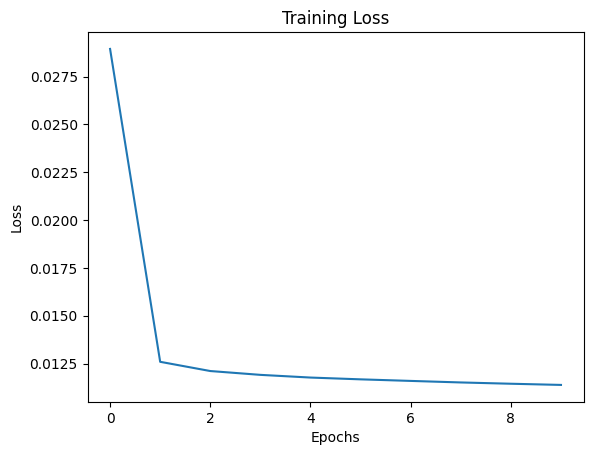

In [13]:
dip_model = DIP().cuda()
losses = train_dip_with_ddpm_guidance(dip_model, trainloader, epochs=10, noise_levels=[0.1, 0.2, 0.3])

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

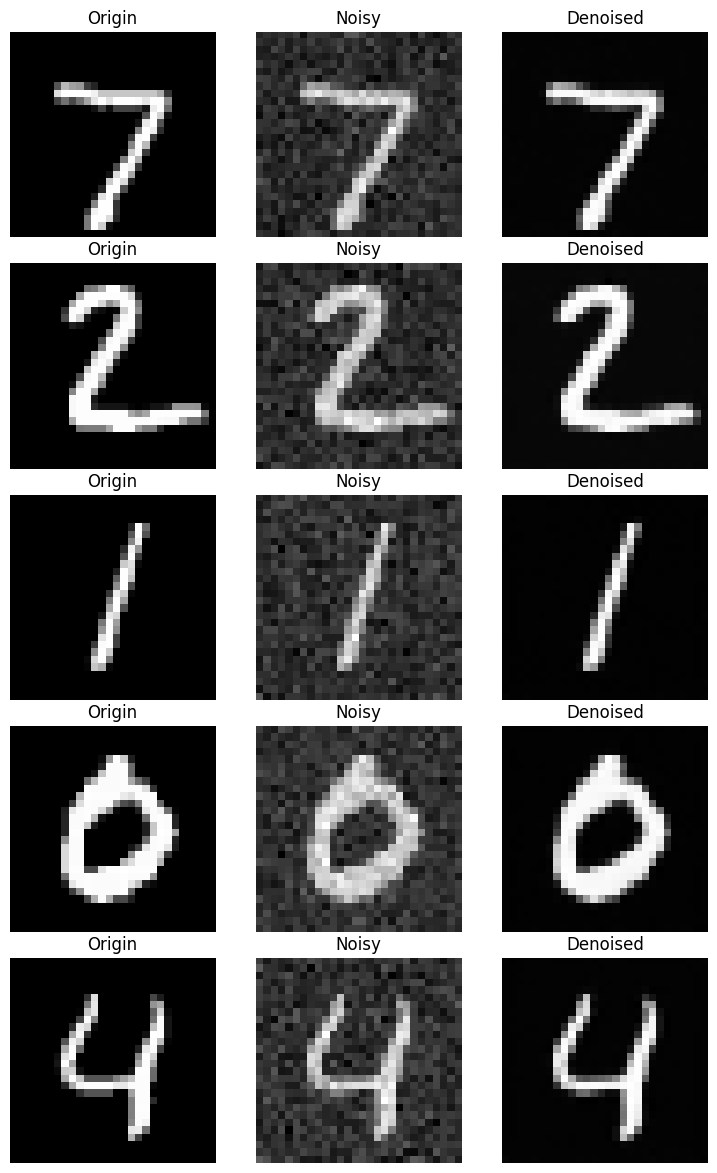

In [15]:
def show_train_images(dip_model, trainloader, noise_level=0.2, num_images=5):
  dataiter = iter(trainloader)
  images, _ = next(dataiter)
  images = images.cuda()

  noisy_images = add_noise(images, noise_level)
  denoised_images = dip_model(noisy_images)

  display_images(images, noisy_images, denoised_images, num_images)

show_train_images(dip_model, testloader, noise_level=0.2, num_images=5)

## 7. 評估函數

In [18]:
def test_dip_with_ddpm_guidance(dip_model, testloader, noise_levels=[0.1, 0.2, 0.3]):
    criterion = nn.MSELoss()
    dip_model.eval()

    losses = []

    with torch.no_grad():
        running_loss = 0.0
        for i, (images, _) in enumerate(testloader):
            images = images.cuda()

            noisy_images = [add_noise(images, nl) for nl in noise_levels]
            loss = 0.0

            for noisy_img in noisy_images:
                output = dip_model(noisy_img)
                loss += criterion(output, images)

            running_loss += loss.item()

        avg_loss = running_loss / len(testloader)
        losses.append(avg_loss)

    return losses


def display_images(clean_img, noisy_img, denoised_img, num_images=5):
  clean_img = clean_img.cpu().detach().numpy()
  noisy_img = noisy_img.cpu().detach().numpy()
  denoised_img = denoised_img.cpu().detach().numpy()

  fig, axes = plt.subplots(num_images, 3, figsize=(9, num_images * 3))
  for i in range(num_images):
    axes[i, 0].imshow(clean_img[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Origin')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy_img[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Noisy')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(denoised_img[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Denoised')
    axes[i, 2].axis('off')

  plt.show()


Loss: 0.0113


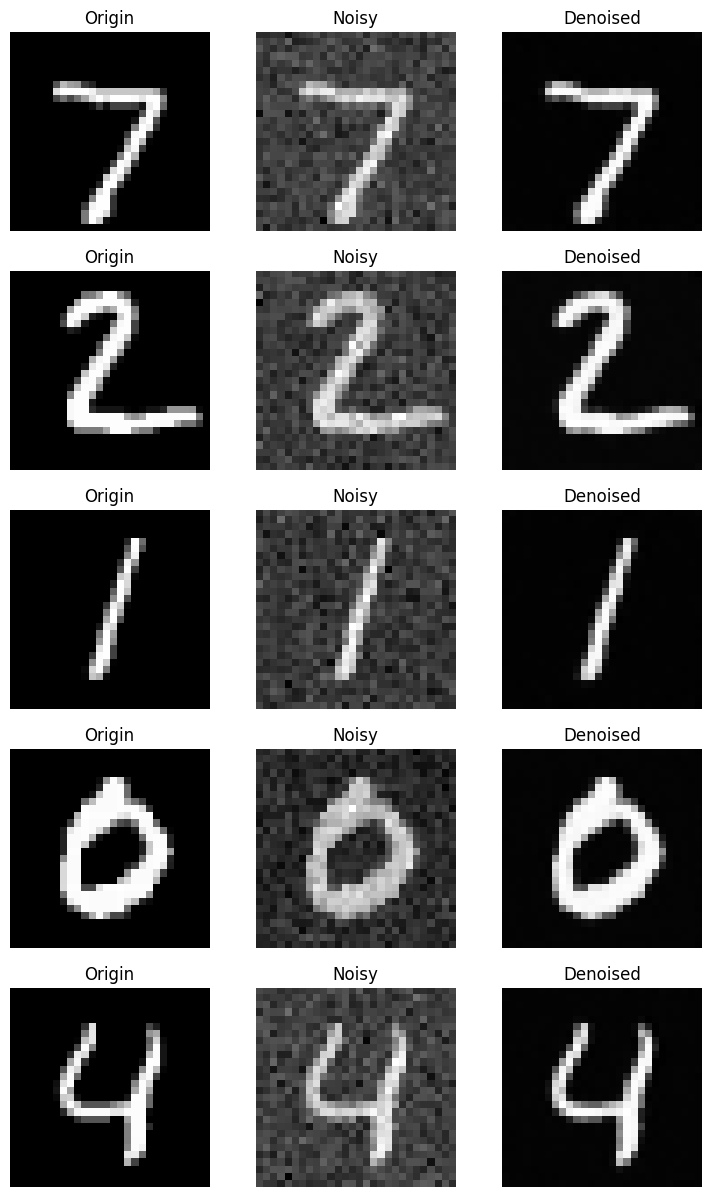

In [23]:
losses = test_dip_with_ddpm_guidance(dip_model, trainloader, noise_levels=[0.1, 0.2, 0.3])

def show_test_images(dip_model, testloader, noise_level=0.2, num_images=5):
  dataiter = iter(testloader)
  images, _ = next(dataiter)
  images = images.cuda()

  noisy_images = add_noise(images, noise_level)
  denoised_images = dip_model(noisy_images)

  display_images(images, noisy_images, denoised_images, num_images)

show_test_images(dip_model, testloader, noise_level=0.2, num_images=5)

## 8. 消融研究

Testing noise levels: [0.1, 0.2, 0.3]
Epoch [1/10], Loss: 0.0115
Epoch [2/10], Loss: 0.0113
Epoch [3/10], Loss: 0.0112
Epoch [4/10], Loss: 0.0111
Epoch [5/10], Loss: 0.0111
Epoch [6/10], Loss: 0.0111
Epoch [7/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0110
Epoch [9/10], Loss: 0.0110
Epoch [10/10], Loss: 0.0109
Testing noise levels: [0.05, 0.1, 0.15]
Epoch [1/10], Loss: 0.0042
Epoch [2/10], Loss: 0.0037
Epoch [3/10], Loss: 0.0037
Epoch [4/10], Loss: 0.0036
Epoch [5/10], Loss: 0.0036
Epoch [6/10], Loss: 0.0036
Epoch [7/10], Loss: 0.0036
Epoch [8/10], Loss: 0.0036
Epoch [9/10], Loss: 0.0036
Epoch [10/10], Loss: 0.0036
Testing noise levels: [0.2, 0.3, 0.4]
Epoch [1/10], Loss: 0.0204
Epoch [2/10], Loss: 0.0195
Epoch [3/10], Loss: 0.0194
Epoch [4/10], Loss: 0.0193
Epoch [5/10], Loss: 0.0192
Epoch [6/10], Loss: 0.0192
Epoch [7/10], Loss: 0.0191
Epoch [8/10], Loss: 0.0191
Epoch [9/10], Loss: 0.0191
Epoch [10/10], Loss: 0.0191


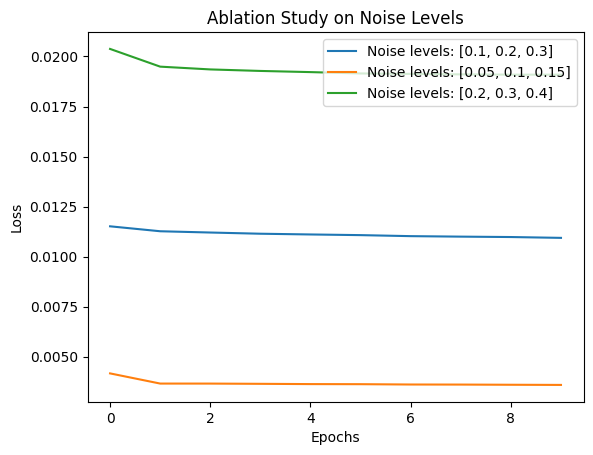

In [24]:
def ablation_study(dip_model, trainloader, noise_levels_list):
  results = {}
  for noise_levels in noise_levels_list:
    print(f"Testing noise levels: {noise_levels}")
    losses = train_dip_with_ddpm_guidance(dip_model, trainloader, epochs=10, noise_levels=noise_levels)
    results[str(noise_levels)] = losses

  return results

noise_levels_list = [[0.1, 0.2, 0.3], [0.05, 0.1, 0.15], [0.2, 0.3, 0.4]]
results = ablation_study(dip_model, trainloader, noise_levels_list)

for noise_levels, losses in results.items():
  plt.plot(losses, label=f'Noise levels: {noise_levels}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Ablation Study on Noise Levels')
plt.legend()
plt.show()

## 評估和比較性能

In [27]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import time

def evaluate_model(model, dataloader, noise_level):
  model.eval()
  total_psnr = 0
  total_ssim = 0
  num_images = 0
  start_time = time.time()

  with torch.no_grad():
    for images, _ in dataloader:
      images = images.cuda()
      noisy_images = add_noise(images, noise_level)
      denoised_images = model(noisy_images)

      for i in range(images.size(0)):
        clean_img = images[i].cpu().numpy().squeeze()
        denoised_img = denoised_images[i].cpu().numpy().squeeze()
        total_psnr += psnr(clean_img, denoised_img, data_range=clean_img.max() - clean_img.min())
        total_ssim += ssim(clean_img, denoised_img, data_range=clean_img.max() - clean_img.min())
        num_images += 1

  avg_psnr = total_psnr / num_images
  avg_ssim = total_ssim / num_images
  total_time = time.time() - start_time
  return avg_psnr, avg_ssim, total_time

dip_psnr, dip_ssim, dip_time = evaluate_model(dip_model, testloader, noise_level=0.2)
print(f'DIP - PSNR: {dip_psnr}, SSIM: {dip_ssim}, Time: {dip_time}')

def evaluate_ddpm(model, dataloader, noise_level=0.2):
  model.eval()
  total_psnr = 0
  total_ssim = 0
  num_images = 0
  start_time = time.time()

  with torch.no_grad():
    for images, _ in dataloader:
      images = images.cuda()
      noisy_images = add_noise(images, noise_level)
      denoised_images = model(noisy_images)

      if isinstance(denoised_images, torch.Tensor):
        denoised_images = denoised_images.cpu().numpy()

      if np.isscalar(denoised_images) or denoised_images.ndim == 0:
        denoised_images = np.array([denoised_images])

      for i in range(images.size(0)):
        clean_img = images[i].cpu().numpy().squeeze()

        denoised_img = denoised_images[i].squeeze() if len(denoised_images) > 1 else denoised_images.squeeze()

        if isinstance(denoised_img, float):
          denoised_img = denoised_img
        else:
          denoised_img = resize(denoised_img, clean_img.shape, anti_aliasing=True)

        total_psnr += psnr(clean_img, denoised_img, data_range=clean_img.max() - clean_img.min())
        total_ssim += ssim(clean_img, denoised_img, data_range=clean_img.max() - clean_img.min())
        num_images += 1

  avg_psnr = total_psnr / num_images
  avg_ssim = total_ssim / num_images
  total_time = time.time() - start_time
  return avg_psnr, avg_ssim, total_time

psnr_ddpm, ssim_ddpm, ddpm_time = evaluate_ddpm(diffusion, testloader, noise_level=0.2)
print(f'DDPM - PSNR: {psnr_ddpm}, SSIM: {ssim_ddpm}, Time: {ddpm_time}')

combined_psnr, combined_ssim, combined_time = evaluate_model(dip_model, testloader, noise_level=0.2)
print(f'Combined - PSNR: {combined_psnr}, SSIM: {combined_ssim}, Time: {combined_time}')


DIP - PSNR: 28.425744420036494, SSIM: 0.966815156301428, Time: 7.393675327301025
DDPM - PSNR: 1.838413918314804, SSIM: -0.23770180582089323, Time: 12.910062074661255
Combined - PSNR: 30.83165863574036, SSIM: 0.9800663372988161, Time: 7.129502296447754
